# 附錄二

## 4.4 實際例子

#### UCI 信用卡資料: https://reurl.cc/2Zy0mm

## PACKAGE

In [1]:
cd ..

C:\Users\innocence846\Desktop\論文\bayesian_tree-master\do


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_score, \
    recall_score, f1_score
from imblearn.over_sampling import SMOTE
import time
import matplotlib.pyplot as plt

In [3]:
from bayesian_decision_tree.classification import PerpendicularClassificationTree
from examples import helper

from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier

In [4]:
from sklearn.model_selection import RandomizedSearchCV
import random
from sklearn import metrics
from sklearn.metrics import classification_report

In [21]:
import time 

## DATA檢視

In [5]:
data = pd.read_csv('./examples/default of credit card clients Data Set.csv')
data

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29998,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [6]:
x = np.array(data)[1:, 1:24]
y = np.array(data)[1:, 24]

for  i in range(0,len(x)) :
    x[i] = pd.to_numeric(x[i])
y = pd.to_numeric(y)

print( 'Amount of Label 0: {}'.format(len(x[y==0]) ))
print( 'Amount of Label 1: {}'.format(len(x[y==1]) ))

Amount of Label 0: 23364
Amount of Label 1: 6636


In [7]:
sm = SMOTE(random_state=1)
x_sm, y_sm = sm.fit_resample(x, y)  

x_train, x_test, y_train, y_test = train_test_split(x_sm, y_sm, test_size=0.2,  random_state=1) 
xo_train, xo_test, yo_train, yo_test = train_test_split(x, y, test_size=0.2,  random_state=1) 

## 模型套用

## GMT

### 參數挑選

#### 原始

In [11]:
n_classes = len(np.unique(y))
    
# prior
prior_pseudo_observations = 1
prior = prior_pseudo_observations * np.ones(n_classes) / (n_classes^5) 

# model
gmt = PerpendicularClassificationTree(
    #partition_prior=0.9,
    prior=prior,
    #delta=0, 
    prune=False) #分類

param_distribs = {
    'partition_prior': np.linspace(0.01,0.99,40),
    'delta': np.linspace(0,1,40)
}

gmt_search = RandomizedSearchCV(gmt, 
    param_distributions=param_distribs, n_iter=100, cv=50, 
    scoring='f1', random_state=1)

gmt_search.fit(xo_train, yo_train)
go_model = gmt_search.best_estimator_
gmt_search.best_params_

{'partition_prior': 0.21102564102564103, 'delta': 0.0}

#### smote

In [12]:
# model
gmt = PerpendicularClassificationTree(
    #partition_prior=0.9,
    prior=prior,
    #delta=0, 
    prune=False) #分類

param_distribs = {
    'partition_prior': np.linspace(0.01,0.99,40),
    'delta': np.linspace(0,1,40)
}

gmt_search = RandomizedSearchCV(gmt, 
    param_distributions=param_distribs, n_iter=100, cv=50, 
    scoring='f1', random_state=1)

gmt_search.fit(x_train, y_train)
g_model = gmt_search.best_estimator_
gmt_search.best_params_

{'partition_prior': 0.21102564102564103, 'delta': 0.0}

### 訓練

#### 原始

In [23]:
%%time 
tn_train, fp_train, fn_train, tp_train = 0, 0, 0, 0
tn_test, fp_test, fn_test, tp_test = 0, 0, 0, 0
imp = 0

for i in range(0,100):
    xo_train2, xo_test2, yo_train2, yo_test2 = train_test_split(x, y, test_size=0.2)  
    go_model.fit(xo_train2, yo_train2)
    y_pred_train = go_model.predict(xo_train2)
    y_pred_test = go_model.predict(xo_test2)
          
    tp1, fn1, fp1, tn1 = confusion_matrix(yo_train2, y_pred_train).ravel()
    tp2, fn2, fp2, tn2 = confusion_matrix(yo_test2, y_pred_test).ravel() 
    
    tn_train = tn1 + tn_train
    fp_train = fp1 + fp_train
    fn_train = fn1 + fn_train
    tp_train = tp1 + tp_train
    
    tn_test = tn2 + tn_test
    fp_test = fp2 + fp_test
    fn_test = fn2 + fn_test
    tp_test = tp2 + tp_test
    
    imp2 = go_model.feature_importance()
    imp = imp + imp2

print('Train matrix: \n{}'.format((tp_train/100, fp_train/100, fn_train/100, tn_train/100)))
print('Test matrix: \n{}\n'.format((tp_test/100, fp_test/100, fn_test/100, tn_test/100)))

recall_0 = tp_test/(tp_test+fn_test)
precision_0 = tp_test/(tp_test+fp_test)
recall_1 = tn_test/(tn_test+fp_test)
precision_1 = tn_test/(tn_test+fn_test)

score = {
    "Score" : ["precision", "recall",  "f1-score"],
    "y=0(多)" : [precision_0, recall_0, 2*((precision_0*recall_0)/(precision_0 + recall_0))],
    "y=1(少)" : [precision_1, recall_1, 2*((precision_1*recall_1)/(precision_1 + recall_1))]
}
sc = pd.DataFrame(score)
print(sc)



Train matrix: 
(17727.18, 3328.46, 966.01, 1978.35)
Test matrix: 
(4427.34, 834.34, 243.47, 494.85)

       Score    y=0(多)    y=1(少)
0  precision  0.841431  0.670238
1     recall  0.947874  0.372294
2   f1-score  0.891486  0.478692
Wall time: 1min 1s


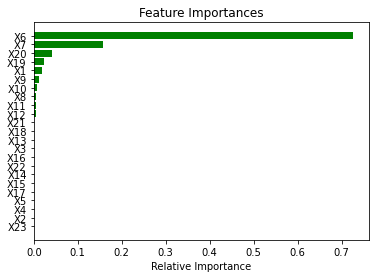

In [24]:
features = list(data)[1:-1]
sorted(zip(imp/100, features), reverse=True)
ind = np.argsort(imp/100)

plt.title('Feature Importances')
plt.barh(range(len(ind)), (imp/100)[ind], color='g', align='center')
plt.yticks(range(len(ind)), [features[i] for i in ind])
plt.xlabel('Relative Importance')
plt.show()

#### SMOTE

In [88]:
%%time
tn_train, fp_train, fn_train, tp_train = 0, 0, 0, 0
tn_test, fp_test, fn_test, tp_test = 0, 0, 0, 0
imp = 0

for i in range(0,100):
    x_train2, x_test2, y_train2, y_test2 = train_test_split(x_sm, y_sm, test_size=0.2)  
    g_model.fit(x_train2, y_train2)
    y_pred_train = g_model.predict(x_train2)
    y_pred_test = g_model.predict(x_test2)
    
    tp1, fn1, fp1, tn1 = confusion_matrix(y_train2, y_pred_train).ravel()
    tp2, fn2, fp2, tn2 = confusion_matrix(y_test2, y_pred_test).ravel()
    
    tn_train = tn1 + tn_train
    fp_train = fp1 + fp_train
    fn_train = fn1 + fn_train
    tp_train = tp1 + tp_train
    
    tn_test = tn2 + tn_test
    fp_test = fp2 + fp_test
    fn_test = fn2 + fn_test
    tp_test = tp2 + tp_test
    
    imp2 = g_model.feature_importance()
    imp = imp + imp2

print('Train matrix: \n{}'.format((tp_train/100, fp_train/100, fn_train/100, tn_train/100)))
print('Test matrix: \n{}\n'.format((tp_test/100, fp_test/100, fn_test/100, tn_test/100)))

recall_0 = tp_test/(tp_test+fn_test)
precision_0 = tp_test/(tp_test+fp_test)
recall_1 = tn_test/(tn_test+fp_test)
precision_1 = tn_test/(tn_test+fn_test)

score = {
    "Score" : ["precision", "recall",  "f1-score"],
    "y=0(多)" : [precision_0, recall_0, 2*((precision_0*recall_0)/(precision_0 + recall_0))],
    "y=1(少)" : [precision_1, recall_1, 2*((precision_1*recall_1)/(precision_1 + recall_1))]
}
sc = pd.DataFrame(score)
print(sc)

Train matrix: 
(17418.4, 4794.5, 1272.45, 13896.65)
Test matrix: 
(4345.78, 1216.33, 327.37, 3456.52)

       Score    y=0(多)    y=1(少)
0  precision  0.781319  0.913483
1     recall  0.929947  0.739703
2   f1-score  0.849178  0.817459
Wall time: 1min 55s


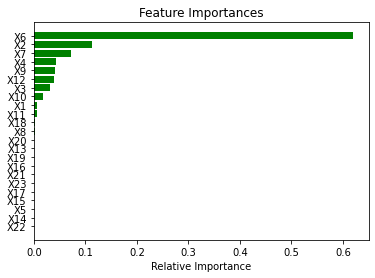

In [89]:
features = list(data)[1:-1]
sorted(zip(imp/100, features), reverse=True)
ind = np.argsort(imp/100)

plt.title('Feature Importances')
plt.barh(range(len(ind)), (imp/100)[ind], color='g', align='center')
plt.yticks(range(len(ind)), [features[i] for i in ind])
plt.xlabel('Relative Importance')
plt.show()

# DT

### 挑選參數

#### 原始

In [13]:
param_distribs = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(low=2, high=15)
}

dt_cf = DecisionTreeClassifier(random_state=1)
dt_search = RandomizedSearchCV(dt_cf, param_distributions=param_distribs, 
                                n_iter=100, cv=50, scoring='f1', random_state=1)
dt_search.fit(xo_train, yo_train)

do_model = dt_search.best_estimator_
dt_search.best_params_

{'criterion': 'gini', 'max_depth': 3}

#### SMOTE

In [14]:
param_distribs = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(low=2, high=15)
}

dt_cf = DecisionTreeClassifier(random_state=1)
dt_search = RandomizedSearchCV(dt_cf, param_distributions=param_distribs, 
                                n_iter=100, cv=50, scoring='f1', random_state=1)
dt_search.fit(x_train, y_train)

d_model = dt_search.best_estimator_
dt_search.best_params_

{'criterion': 'gini', 'max_depth': 12}

### 訓練

#### 原始

In [90]:
%%time
tn_train, fp_train, fn_train, tp_train = 0, 0, 0, 0
tn_test, fp_test, fn_test, tp_test = 0, 0, 0, 0
imp = 0

for i in range(0,100):
    xo_train2, xo_test2, yo_train2, yo_test2 = train_test_split(x, y, test_size=0.2)  
    do_model.fit(xo_train2, yo_train2)
    y_pred_train = do_model.predict(xo_train2)
    y_pred_test = do_model.predict(xo_test2)
          
    tp1, fn1, fp1, tn1 = confusion_matrix(yo_train2, y_pred_train).ravel()
    tp2, fn2, fp2, tn2 = confusion_matrix(yo_test2, y_pred_test).ravel() 
    
    tn_train = tn1 + tn_train
    fp_train = fp1 + fp_train
    fn_train = fn1 + fn_train
    tp_train = tp1 + tp_train
    
    tn_test = tn2 + tn_test
    fp_test = fp2 + fp_test
    fn_test = fn2 + fn_test
    tp_test = tp2 + tp_test
    
    imp2 = do_model.feature_importances_
    imp = imp + imp2

print('Train matrix: \n{}'.format((tp_train/100, fp_train/100, fn_train/100, tn_train/100)))
print('Test matrix: \n{}\n'.format((tp_test/100, fp_test/100, fn_test/100, tn_test/100)))

recall_0 = tp_test/(tp_test+fn_test)
precision_0 = tp_test/(tp_test+fp_test)
recall_1 = tn_test/(tn_test+fp_test)
precision_1 = tn_test/(tn_test+fn_test)

score = {
    "Score" : ["precision", "recall",  "f1-score"],
    "y=0(多)" : [precision_0, recall_0, 2*((precision_0*recall_0)/(precision_0 + recall_0))],
    "y=1(少)" : [precision_1, recall_1, 2*((precision_1*recall_1)/(precision_1 + recall_1))]
}
sc = pd.DataFrame(score)
print(sc)

Train matrix: 
(17745.08, 3320.98, 948.85, 1985.09)
Test matrix: 
(4429.3, 836.8, 240.77, 493.13)

       Score    y=0(多)    y=1(少)
0  precision  0.841097  0.671931
1     recall  0.948444  0.370794
2   f1-score  0.891551  0.477879
Wall time: 12.8 s


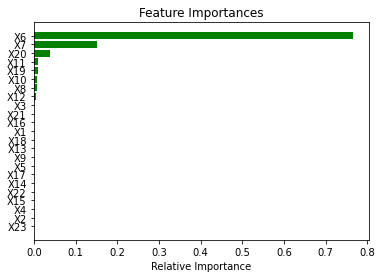

In [91]:
features = list(data)[1:-1]
sorted(zip(imp/100, features), reverse=True)
ind = np.argsort(imp/100)

plt.title('Feature Importances')
plt.barh(range(len(ind)), (imp/100)[ind], color='g', align='center')
plt.yticks(range(len(ind)), [features[i] for i in ind])
plt.xlabel('Relative Importance')
plt.show()

#### SMOTE

In [92]:
%%time
tn_train, fp_train, fn_train, tp_train = 0, 0, 0, 0
tn_test, fp_test, fn_test, tp_test = 0, 0, 0, 0
imp = 0

for i in range(0,100):
    x_train2, x_test2, y_train2, y_test2 = train_test_split(x_sm, y_sm, test_size=0.2)  
    d_model.fit(x_train2, y_train2)
    y_pred_train = d_model.predict(x_train2)
    y_pred_test = d_model.predict(x_test2)
          
    tp1, fn1, fp1, tn1 = confusion_matrix(y_train2, y_pred_train).ravel()
    tp2, fn2, fp2, tn2 = confusion_matrix(y_test2, y_pred_test).ravel() 
    
    tn_train = tn1 + tn_train
    fp_train = fp1 + fp_train
    fn_train = fn1 + fn_train
    tp_train = tp1 + tp_train
    
    tn_test = tn2 + tn_test
    fp_test = fp2 + fp_test
    fn_test = fn2 + fn_test
    tp_test = tp2 + tp_test
    
    imp2 = d_model.feature_importances_
    imp = imp + imp2

print('Train matrix: \n{}'.format((tp_train/100, fp_train/100, fn_train/100, tn_train/100)))
print('Test matrix: \n{}\n'.format((tp_test/100, fp_test/100, fn_test/100, tn_test/100)))

recall_0 = tp_test/(tp_test+fn_test)
precision_0 = tp_test/(tp_test+fp_test)
recall_1 = tn_test/(tn_test+fp_test)
precision_1 = tn_test/(tn_test+fn_test)

score = {
    "Score" : ["precision", "recall",  "f1-score"],
    "y=0(多)" : [precision_0, recall_0, 2*((precision_0*recall_0)/(precision_0 + recall_0))],
    "y=1(少)" : [precision_1, recall_1, 2*((precision_1*recall_1)/(precision_1 + recall_1))]
}
sc = pd.DataFrame(score)
print(sc)

Train matrix: 
(17609.4, 3006.78, 1080.1, 15685.72)
Test matrix: 
(4184.86, 971.61, 489.64, 3699.89)

       Score    y=0(多)    y=1(少)
0  precision  0.811575  0.883128
1     recall  0.895253  0.792013
2   f1-score  0.851363  0.835093
Wall time: 44.3 s


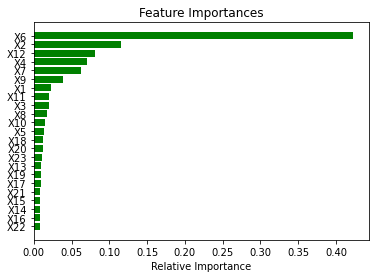

In [93]:
features = list(data)[1:-1]
sorted(zip(imp/100, features), reverse=True)
ind = np.argsort(imp/100)

plt.title('Feature Importances')
plt.barh(range(len(ind)), (imp/100)[ind], color='g', align='center')
plt.yticks(range(len(ind)), [features[i] for i in ind])
plt.xlabel('Relative Importance')
plt.show()

# RF

### 挑選參數

#### 原始

In [15]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'criterion': ['gini', 'entropy']
}

rnd_cf = RandomForestClassifier(random_state=1)
rnd_search = RandomizedSearchCV(rnd_cf, param_distributions=param_distribs, 
                                n_iter=100, cv=50, scoring='f1', random_state=1)
rnd_search.fit(xo_train, yo_train)

rfo_model = rnd_search.best_estimator_
rnd_search.best_params_

{'criterion': 'gini', 'n_estimators': 161}

#### SMOTE

In [16]:
param_distribs = {
    'n_estimators': randint(low=1, high=200),
    'criterion': ['gini', 'entropy']
}

rnd_cf = RandomForestClassifier(random_state=1)
rnd_search = RandomizedSearchCV(rnd_cf, param_distributions=param_distribs, 
                                n_iter=100, cv=50, scoring='f1', random_state=1)
rnd_search.fit(x_train, y_train)

rf_model = rnd_search.best_estimator_
rnd_search.best_params_

{'criterion': 'gini', 'n_estimators': 197}

### 訓練

#### 原始

In [94]:
%%time
tn_train, fp_train, fn_train, tp_train = 0, 0, 0, 0
tn_test, fp_test, fn_test, tp_test = 0, 0, 0, 0
imp = 0

for i in range(0,100):
    xo_train2, xo_test2, yo_train2, yo_test2 = train_test_split(x, y, test_size=0.2)  
    rfo_model.fit(xo_train2, yo_train2)
    y_pred_train = rfo_model.predict(xo_train2)
    y_pred_test = rfo_model.predict(xo_test2)
          
    tp1, fn1, fp1, tn1 = confusion_matrix(yo_train2, y_pred_train).ravel()
    tp2, fn2, fp2, tn2 = confusion_matrix(yo_test2, y_pred_test).ravel() 
    
    tn_train = tn1 + tn_train
    fp_train = fp1 + fp_train
    fn_train = fn1 + fn_train
    tp_train = tp1 + tp_train
    
    tn_test = tn2 + tn_test
    fp_test = fp2 + fp_test
    fn_test = fn2 + fn_test
    tp_test = tp2 + tp_test
    
    imp2 = rfo_model.feature_importances_
    imp = imp + imp2

print('Train matrix: \n{}'.format((tp_train/100, fp_train/100, fn_train/100, tn_train/100)))
print('Test matrix: \n{}\n'.format((tp_test/100, fp_test/100, fn_test/100, tn_test/100)))

recall_0 = tp_test/(tp_test+fn_test)
precision_0 = tp_test/(tp_test+fp_test)
recall_1 = tn_test/(tn_test+fp_test)
precision_1 = tn_test/(tn_test+fn_test)

score = {
    "Score" : ["precision", "recall",  "f1-score"],
    "y=0(多)" : [precision_0, recall_0, 2*((precision_0*recall_0)/(precision_0 + recall_0))],
    "y=1(少)" : [precision_1, recall_1, 2*((precision_1*recall_1)/(precision_1 + recall_1))]
}
sc = pd.DataFrame(score)
print(sc)

Train matrix: 
(18688.65, 9.7, 4.47, 5297.18)
Test matrix: 
(4399.56, 831.1, 271.32, 498.02)

       Score    y=0(多)    y=1(少)
0  precision  0.841110  0.647334
1     recall  0.941912  0.374699
2   f1-score  0.888662  0.474653
Wall time: 12min 44s


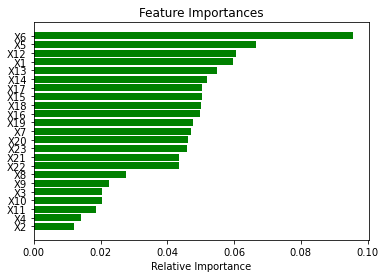

In [95]:
features = list(data)[1:-1]
sorted(zip(imp/100, features), reverse=True)
ind = np.argsort(imp/100)

plt.title('Feature Importances')
plt.barh(range(len(ind)), (imp/100)[ind], color='g', align='center')
plt.yticks(range(len(ind)), [features[i] for i in ind])
plt.xlabel('Relative Importance')
plt.show()

#### SMOTE

In [96]:
%%time
tn_train, fp_train, fn_train, tp_train = 0, 0, 0, 0
tn_test, fp_test, fn_test, tp_test = 0, 0, 0, 0
imp = 0

for i in range(0,100):
    x_train2, x_test2, y_train2, y_test2 = train_test_split(x_sm, y_sm, test_size=0.2)  
    rf_model.fit(x_train2, y_train2)
    y_pred_train = rf_model.predict(x_train2)
    y_pred_test = rf_model.predict(x_test2)
          
    tp1, fn1, fp1, tn1 = confusion_matrix(y_train2, y_pred_train).ravel()
    tp2, fn2, fp2, tn2 = confusion_matrix(y_test2, y_pred_test).ravel() 
    
    tn_train = tn1 + tn_train
    fp_train = fp1 + fp_train
    fn_train = fn1 + fn_train
    tp_train = tp1 + tp_train
    
    tn_test = tn2 + tn_test
    fp_test = fp2 + fp_test
    fn_test = fn2 + fn_test
    tp_test = tp2 + tp_test
    
    imp2 = rf_model.feature_importances_
    imp = imp + imp2

print('Train matrix: \n{}'.format((tp_train/100, fp_train/100, fn_train/100, tn_train/100)))
print('Test matrix: \n{}\n'.format((tp_test/100, fp_test/100, fn_test/100, tn_test/100)))

recall_0 = tp_test/(tp_test+fn_test)
precision_0 = tp_test/(tp_test+fp_test)
recall_1 = tn_test/(tn_test+fp_test)
precision_1 = tn_test/(tn_test+fn_test)

score = {
    "Score" : ["precision", "recall",  "f1-score"],
    "y=0(多)" : [precision_0, recall_0, 2*((precision_0*recall_0)/(precision_0 + recall_0))],
    "y=1(少)" : [precision_1, recall_1, 2*((precision_1*recall_1)/(precision_1 + recall_1))]
}
sc = pd.DataFrame(score)
print(sc)

Train matrix: 
(18681.73, 8.64, 5.53, 18686.1)
Test matrix: 
(4334.17, 755.17, 342.57, 3914.09)

       Score    y=0(多)    y=1(少)
0  precision  0.851617  0.919521
1     recall  0.926750  0.838268
2   f1-score  0.887597  0.877017
Wall time: 22min 1s


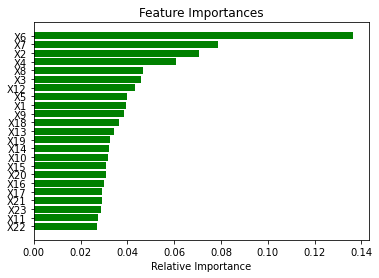

In [97]:
features = list(data)[1:-1]
sorted(zip(imp/100, features), reverse=True)
ind = np.argsort(imp/100)

plt.title('Feature Importances')
plt.barh(range(len(ind)), (imp/100)[ind], color='g', align='center')
plt.yticks(range(len(ind)), [features[i] for i in ind])
plt.xlabel('Relative Importance')
plt.show()

## 各指標的長條圖

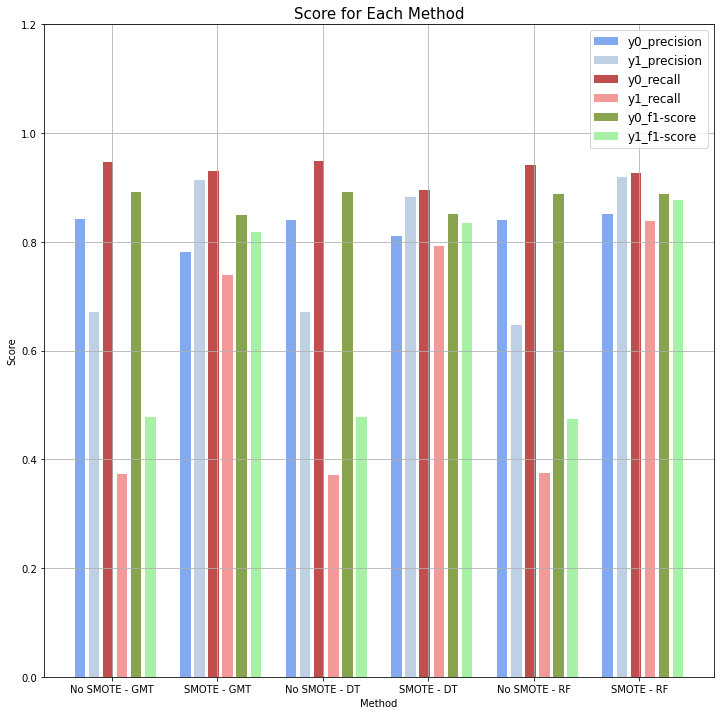

In [108]:
method_count = 6 #列出三個方法的SMOTE前與後
bar_width = 0.3 #長條寬度
index = 3*np.arange(method_count)

#擷取三個評估值的數字
y_0_precision = [0.841431, 0.781319, 0.841097, 0.811575, 0.841110, 0.851617]
y_1_precision = [0.670238, 0.913483, 0.671931, 0.883128, 0.647334, 0.919521]
y_0_recall    = [0.947874, 0.929947, 0.948444, 0.895253, 0.941912, 0.926750]
y_1_recall    = [0.372294, 0.739703, 0.370794, 0.792013, 0.374699, 0.838268]
y_0_f1score   = [0.891486, 0.849478, 0.891551, 0.851363, 0.888662, 0.887597]
y_1_f1score   = [0.478692, 0.817459, 0.477879, 0.835093, 0.474653, 0.877017]

plt.figure(figsize=(12,12))

y_0_precision = plt.bar(index,         #長條圖位置
                       y_0_precision,  #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'cornflowerblue',    
                       label = "y0_precision")
y_1_precision = plt.bar(index+0.4,     #長條圖位置
                       y_1_precision,  #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'lightsteelblue',   
                       label = "y1_precision")
y_0_recall    = plt.bar(index+0.8,     #長條圖位置
                       y_0_recall,     #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'firebrick',   
                       label = "y0_recall")
y_1_recall    = plt.bar(index+1.2,     #長條圖位置
                       y_1_recall,     #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'lightcoral',   
                       label = "y1_recall")
y_0_f1score   = plt.bar(index+1.6,     #長條圖位置
                       y_0_f1score,    #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'olivedrab',   
                       label = "y0_f1-score")
y_1_f1score   = plt.bar(index+2,     #長條圖位置
                       y_1_f1score,    #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'lightgreen',   
                       label = "y1_f1-score")

# 長條圖左上的標籤
def createLabels(data):                   # 自定義函數，為引用plusone團隊
    for item in data:
        height = item.get_height()
        #plt.text(                        # 數值顯示
        #    item.get_x()+item.get_width()/2., 
        #    height*1.05, 
        #    '%d' % int(height),
        #    ha = "center",
        #    va = "bottom",
        #)
createLabels(y_0_precision)
createLabels(y_1_precision)
createLabels(y_0_recall)
createLabels(y_1_recall)
createLabels(y_0_f1score)
createLabels(y_1_f1score)

plt.ylabel("Score")          # 設定y軸標題 
plt.xlabel("Method")            # 設定x軸標題
plt.title("Score for Each Method", {'fontsize' : 15})  # 設定標題、文字大小
plt.xticks(index+3*bar_width ,("No SMOTE - GMT", "SMOTE - GMT", "No SMOTE - DT", "SMOTE - DT", "No SMOTE - RF", "SMOTE - RF"))  #.xticks為x軸文字(為了置中所以+0.3/2)
plt.ylim(0, 1.2)                 # 設定y軸範圍
plt.legend(prop = {'size':12})    # 設定圖例及其大小
plt.grid(True)                   # 顯示格線

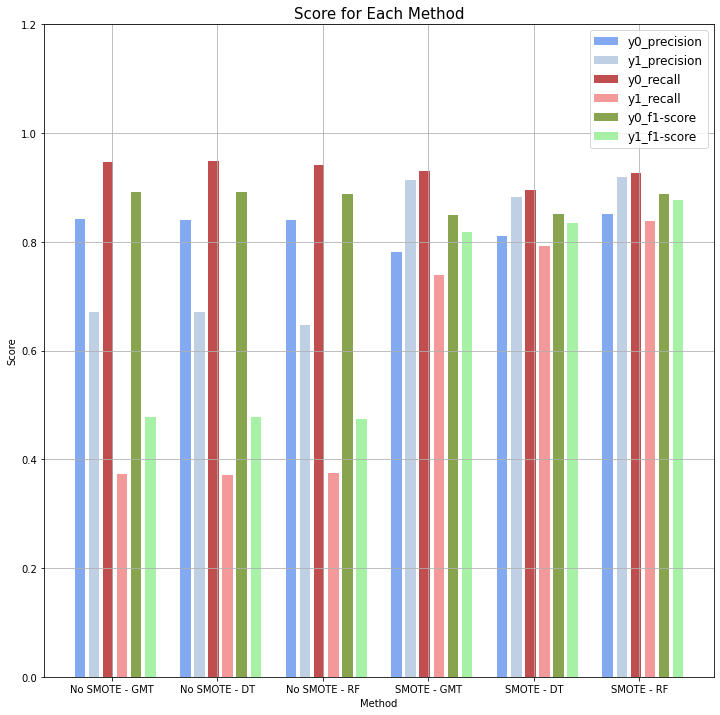

In [109]:
method_count = 6 #列出三個方法的SMOTE前與後
bar_width = 0.3 #長條寬度
index = 3*np.arange(method_count)

#擷取三個評估值的數字
y_0_precision = [0.841431, 0.841097, 0.841110, 0.781319, 0.811575, 0.851617]
y_1_precision = [0.670238, 0.671931, 0.647334, 0.913483, 0.883128, 0.919521]
y_0_recall    = [0.947874, 0.948444, 0.941912, 0.929947, 0.895253, 0.926750]
y_1_recall    = [0.372294, 0.370794, 0.374699, 0.739703, 0.792013, 0.838268]
y_0_f1score   = [0.891486, 0.891551, 0.888662, 0.849478, 0.851363, 0.887597]
y_1_f1score   = [0.478692, 0.477879, 0.474653, 0.817459, 0.835093, 0.877017]

plt.figure(figsize=(12,12))

y_0_precision = plt.bar(index,         #長條圖位置
                       y_0_precision,  #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'cornflowerblue',    
                       label = "y0_precision")
y_1_precision = plt.bar(index+0.4,     #長條圖位置
                       y_1_precision,  #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'lightsteelblue',   
                       label = "y1_precision")
y_0_recall    = plt.bar(index+0.8,     #長條圖位置
                       y_0_recall,     #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'firebrick',   
                       label = "y0_recall")
y_1_recall    = plt.bar(index+1.2,     #長條圖位置
                       y_1_recall,     #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'lightcoral',   
                       label = "y1_recall")
y_0_f1score   = plt.bar(index+1.6,     #長條圖位置
                       y_0_f1score,    #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'olivedrab',   
                       label = "y0_f1-score")
y_1_f1score   = plt.bar(index+2,     #長條圖位置
                       y_1_f1score,    #資料
                       bar_width,      #長條圖寬度
                       alpha = 0.8,    #透明度
                       color = 'lightgreen',   
                       label = "y1_f1-score")

# 長條圖左上的標籤
def createLabels(data):                   # 自定義函數，為引用plusone團隊
    for item in data:
        height = item.get_height()
        #plt.text(                        # 數值顯示
        #    item.get_x()+item.get_width()/2., 
        #    height*1.05, 
        #    '%d' % int(height),
        #    ha = "center",
        #    va = "bottom",
        #)
createLabels(y_0_precision)
createLabels(y_1_precision)
createLabels(y_0_recall)
createLabels(y_1_recall)
createLabels(y_0_f1score)
createLabels(y_1_f1score)

plt.ylabel("Score")          # 設定y軸標題 
plt.xlabel("Method")            # 設定x軸標題
plt.title("Score for Each Method", {'fontsize' : 15})  # 設定標題、文字大小
plt.xticks(index+3*bar_width ,("No SMOTE - GMT", "No SMOTE - DT", "No SMOTE - RF", "SMOTE - GMT", "SMOTE - DT", "SMOTE - RF"))  #.xticks為x軸文字(為了置中所以+0.3/2)
plt.ylim(0, 1.2)                 # 設定y軸範圍
plt.legend(prop = {'size':12})    # 設定圖例及其大小
plt.grid(True)                   # 顯示格線